In [20]:
from subpred.protein_go_datasets import get_transmembrane_transporter_dataset, get_stats

## Full dataset

In [21]:
dataset_human = get_transmembrane_transporter_dataset(
    organism_ids=[9606],
    swissprot_only=False,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=False,
    max_sequence_evidence_code=2,
    remove_proteins_without_gene_names=False,
)
get_stats(*dataset_human)

cd-hit: clustered 3874 sequences into 1029 clusters at threshold 50
cd-hit: clustered 3874 sequences into 1347 clusters at threshold 70
cd-hit: clustered 3874 sequences into 1774 clusters at threshold 90
cd-hit: clustered 3874 sequences into 3408 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence   protein_existence_evidence clustering                   
False              False         computational protein_level              50                       1   
                                                                          70                       1   
                                                                          90                       5   
                                                                          100                      9   
                                                                          None                    10   
                                               transcript_level           50                      54   
                                                                          70                      77   
                                                                          90                     152   
                                                                          100                    665   
                                                                          None                   771   
                                 experiment    transcript_level           50                       1   
                                                                          70                       1   
                                                                          90                       1   
                                                                          100                      2   
                                                                          None                     2   
                   True          computational protein_level              50                     142   
                                                                          70                     211   
                                                                          90                     419   
                                                                          100                   1031   
                                                                          None                  1175   
                                               transcript_level           50                      31   
                                                                          70                      46   
                                                                          90                     100   
                                                                          100                    501   
                                                                          None                   687   
                                 experiment    transcript_level           50                       1   
                                                                          70                       1   
                                                                          90                       2   
                                                                          100                      4   
                                                                          None                     5   
True               True          computational protein_level              50                     552   
                                                                          70                     741   
                                                                          90                     819   
                                                                          100                    919   
                                                                          None                   945   
                                               transcript_level           50                       6   
                                                                          70                      10   
                              

## Filtered Subset

In [22]:
dataset_human = get_transmembrane_transporter_dataset(  # human
    organism_ids=[9606],  # [3702, 9606, 83333, 559292]
    swissprot_only=True,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=True,
    max_sequence_evidence_code=1,
    remove_proteins_without_gene_names=True,
)
get_stats(*dataset_human)

cd-hit: clustered 1121 sequences into 846 clusters at threshold 50
cd-hit: clustered 1121 sequences into 1039 clusters at threshold 70
cd-hit: clustered 1121 sequences into 1110 clusters at threshold 90
cd-hit: clustered 1121 sequences into 1118 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering                   
True               True          experiment  protein_level              50                     846   
                                                                        70                    1039   
                                                                        90                    1110   
                                                                        100                   1118   
                                                                        None                  1121   

                                                                                    n_terms  
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering           
True               True          experiment  protein_level              50              534  
                                                                        70              563  
                                                                        90              570  
                                                                        100             570  
                                                                        None            570

## Sugar/Amino subset

In [23]:
from subpred.evaluation import get_classification_subset
dataset_human = get_classification_subset(
    dataset_full=dataset_human,
    go_terms=[
        "sugar transmembrane transporter activity",
        "amino acid transmembrane transporter activity",
    ],
)

print("before clustering:")
dataset_human[1].go_term_ancestor.value_counts()

before clustering:


go_term_ancestor
amino acid transmembrane transporter activity    96
sugar transmembrane transporter activity         26
Name: count, dtype: int64

In [24]:
dataset_human[0]

,sequence,reviewed,protein_existence,organism_id,protein_names
Uniprot,,,,,
A0PJK1,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,True,1,9606,Sodium/mannose cotransporter SLC5A10 (Sodium/g...
A6NNN8,MEGQTPGSRGLPEKPHPATAAATLSSMGAVFILMKSALGAGLLNFP...,True,1,9606,Solute carrier family 38 member 8 (Amino acid ...
O00341,MVPHAILARGRDVCRRNGLLILSVLSVIVGCLLGFFLRTRRLSPQE...,True,1,9606,Excitatory amino acid transporter 5 (Retinal g...
O15244,MPTTVDDVLEHGGEFHFFQKQMFFLLALLSATFAPIYVGIVFLGFT...,True,1,9606,Solute carrier family 22 member 2 (Organic cat...
O15399,MRGAGGPRGPRGPAKMLLLLALACASPFPEEAPGPGGAGGPGGGLG...,True,1,9606,"Glutamate receptor ionotropic, NMDA 2D (GluN2D..."
...,...,...,...,...,...
Q9UN76,MDKLKCPSFFKCREKEKVSASSENFHVGENDENQDRGNWSKKSDYL...,True,1,9606,Sodium- and chloride-dependent neutral and bas...
Q9UPY5,MVRKPVVSTISKGGYLQGNVNGRLPSLGNKEPPGQEKVQLKRKVTL...,True,1,9606,Cystine/glutamate transporter (Amino acid tran...
Q9Y2W3,MIPAASSTPPGDALFPSVAPQDFWRSQVTGYSGSVTRHLSHRANNF...,True,1,9606,Proton-associated sugar transporter A (PAST-A)...


In [25]:
from subpred.evaluation import filter_no_3Di_available

dataset_human = filter_no_3Di_available(dataset_human)
dataset_human[1].go_term_ancestor.value_counts()

go_term_ancestor
amino acid transmembrane transporter activity    96
sugar transmembrane transporter activity         25
Name: count, dtype: int64

Clustering at 70%

In [26]:
from subpred.evaluation import cluster_sequences

dataset_human = cluster_sequences(
    dataset_full=dataset_human, identity_threshold=70
)
dataset_human[1].go_term_ancestor.value_counts()

cd-hit: clustered 121 sequences into 108 clusters at threshold 70


go_term_ancestor
amino acid transmembrane transporter activity    84
sugar transmembrane transporter activity         24
Name: count, dtype: int64

human:

amino acid transmembrane transporter activity    84

sugar transmembrane transporter activity         25

ecoli:

amino acid transmembrane transporter activity    46

sugar transmembrane transporter activity         19

at:

amino acid transmembrane transporter activity    26

sugar transmembrane transporter activity         28

yeast:

amino acid transmembrane transporter activity    44

sugar transmembrane transporter activity         8

yeast+ecoli

amino acid transmembrane transporter activity    90

sugar transmembrane transporter activity         27

human+at

amino acid transmembrane transporter activity    110

sugar transmembrane transporter activity          53

all four

amino acid transmembrane transporter activity    200

sugar transmembrane transporter activity          80

## Feature generation

In [27]:
from subpred.features import calculate_features
from subpred.pssm import calculate_pssm_feature
from subpred.compositions import calculate_comp, ALPHABET_3DI, AMINO_ACIDS
from subpred.structural_sequences import get_3Di_sequences
from subpred.embeddings import get_nlp_features
import pandas as pd
import numpy as np

def get_features(dataset_full: tuple):
    # Can take a long time if cache is empty
    df_sequences, df_uniprot_goa = dataset_full[0].copy(), dataset_full[1].copy()
    series_sequences = df_sequences.sequence
    series_accessions = df_sequences.index

    # 3Di sequences
    sequences_3Di = get_3Di_sequences(series_accessions)
    # Are there as many 3Di sequences as AA sequences? TODO If yes, maybe take intersection
    assert len(sequences_3Di) == len(series_sequences)  # can be prevented by calling evaluation.filter_PDB_available

    # original sequences features
    df_aac = calculate_comp(series_sequences, k=1, alphabet=AMINO_ACIDS)
    df_paac = calculate_comp(series_sequences, k=2, alphabet=AMINO_ACIDS)
    df_kmer3 = calculate_comp(series_sequences, k=3, alphabet=AMINO_ACIDS)

    pssm_folder = "../data/datasets/pssm/"
    blastdb_folder = "../data/datasets/blastdb/"
    verbosity_pssm = 1  # only print if no pssm found
    df_pssm_50_1 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref50_1it",
        blast_db=blastdb_folder + "uniref50/uniref50.fasta",
        iterations=1,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_50_1",
    )
    df_pssm_50_3 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref50_3it",
        blast_db=blastdb_folder + "uniref50/uniref50.fasta",
        iterations=3,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_50_3",
    )
    df_pssm_90_1 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref90_3it",
        blast_db=blastdb_folder + "uniref90/uniref90.fasta",
        iterations=1,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_90_1",
    )
    df_pssm_90_3 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref90_3it",
        blast_db=blastdb_folder + "uniref90/uniref90.fasta",
        iterations=3,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_90_3",
    )
    df_pssm_meta = pd.concat(
        [df_pssm_50_1, df_pssm_50_3, df_pssm_90_1, df_pssm_90_3], axis=1
    )
    df_meta = calculate_features(
        series_sequences=series_sequences, standardize_samples=False
    )
    df_meta_std = calculate_features(
        series_sequences=series_sequences, standardize_samples=True
    )

    df_3Di_AAC = calculate_comp(sequences=sequences_3Di, k=1, alphabet=ALPHABET_3DI)
    df_3Di_PAAC = calculate_comp(sequences=sequences_3Di, k=2, alphabet=ALPHABET_3DI)
    df_3Di_KMER3 = calculate_comp(sequences=sequences_3Di, k=3, alphabet=ALPHABET_3DI)

    # combining aa and 3di kmers
    df_KMER1_COMBINED = pd.concat([df_3Di_AAC, df_aac], axis=1)
    df_KMER2_COMBINED = pd.concat([df_3Di_PAAC, df_paac], axis=1)
    df_KMER3_COMBINED = pd.concat([df_3Di_KMER3, df_kmer3], axis=1)

    # AA Embeddings
    df_embeddings_prott5_AA = get_nlp_features(
        sequences=series_sequences,
        model="protT5",
        sequence_type="AA",
        half_precision=True,
    )
    df_embeddings_prostt5_AA = get_nlp_features(
        sequences=series_sequences,
        model="prostT5",
        sequence_type="AA",
        half_precision=True,
    )
    # 3Di Embeddings
    df_embeddings_prott5_3Di = get_nlp_features(
        sequences=sequences_3Di,
        model="prostT5",
        sequence_type="3Di",
        half_precision=True,
    )

    np.random.seed(0)
    df_dummy_feature = pd.DataFrame(
        np.random.rand(len(series_accessions), 1024),
        index=series_accessions,
        columns=[f"dummy{i}" for i in range(1024)],
    )

    features_list = [
        ("AAC", df_aac),
        ("PAAC", df_paac),
        ("AA_KMER3", df_kmer3),
        ("PSSM_50_1", df_pssm_50_1),
        ("PSSM_50_3", df_pssm_50_3),
        ("PSSM_90_1", df_pssm_90_1),
        ("PSSM_90_3", df_pssm_90_3),
        ("PSSM_META", df_pssm_meta),
        ("META", df_meta),
        ("META_STD", df_meta_std),
        ("3Di_COMP", df_3Di_AAC),
        ("3Di_KMER2", df_3Di_PAAC),
        ("3Di_KMER3", df_3Di_KMER3),
        ("COMB_KMER1", df_KMER1_COMBINED),
        ("COMB_KMER2", df_KMER2_COMBINED),
        ("COMB_KMER3", df_KMER3_COMBINED),
        ("PROTT5_AA", df_embeddings_prott5_AA),
        ("PROSTT5_AA", df_embeddings_prostt5_AA),
        ("PROSTT5_3DI", df_embeddings_prott5_3Di),
        ("DUMMY", df_dummy_feature),
    ]
    features_list = [
        (feature_name, df_feature.loc[series_accessions])
        for feature_name, df_feature in features_list
    ]
    series_labels = df_uniprot_goa.loc[series_accessions].go_term_ancestor
    return features_list, series_labels

2025-05-25 03:21:47.571094: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 03:21:47.633177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748136107.644254   12235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748136107.648804   12235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-25 03:21:47.718917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [28]:
features_list, series_labels = get_features(dataset_full=dataset_human)

MRAVLDTADIAIVALYFILVMCIGFFAMWKSNRSTVSGYFLAGRSMTWVAIGASLFVSNIGSEHFIGLAGSGAASGFAVGAWEFNALLLLQLLGWVFIPIYIRSGVYTMPEYLSKRFGGHRIQVYFAALSLILYIFTKLSVDLYSGALFIQESLGWNLYVSVILLIGMTALLTVTGGLVAVIYTDTLQALLMIIGALTLMIISIMEIGGFEEVKRRYMLASPDVTSILLTYNLSNTNSCNVSPKKEALKMLRNPTDEDVPWPGFILGQTPASVWYWCADQVIVQRVLAAKNIAHAKGSTLMAGFLKLLPMFIIVVPGMISRILFTDDIACINPEHCMLVCGSRAGCSNIAYPRLVMKLVPVGLRGLMMAVMIAALMSDLDSIFNSASTIFTLDVYKLIRKSASSRELMIVGRIFVAFMVVISIAWVPIIVEMQGGQMYLYIQEVADYLTPPVAALFLLAIFWKRCNEQGAFYGGMAGFVLGAVRLILAFAYRAPECDQPDNRPGFIKDIHYMYVATGLFWVTGLITVIVSLLTPPPTKEQIRTTTFWSKKNLVVKENCSPKEEPYQMQEKSILRCSENNETINHIIPNGKSEDSIKGLQPEDVNLLVTCREEGNPVASLGHSEAETPVDAYSNGQAALMGEKERKKETDDGGRYWKFIDWFCGFKSKSLSKRSLRDLMEEEAVCLQMLEETRQVKVILNIGLFAVCSLGIFMFVYFSL
MRAVLDTADIAIVALYFILVMCIGFFAMWKSNRSTVSGYFLAGRSMTWVAIGASLFVSNIGSEHFIGLAGSGAASGFAVGAWEFNALLLLQLLGWVFIPIYIRSGVYTMPEYLSKRFGGHRIQVYFAALSLILYIFTKLSVDLYSGALFIQESLGWNLYVSVILLIGMTALLTVTGGLVAVIYTDTLQALLMIIGALTLMIISIMEIGGFEEVKRRYMLASPDVTSILLTYNLSNTNSCNVSPKKEALKMLRNPTDEDVPWPGFILGQTPASVWYWCADQV

For each Feature: Outlier detection, numpy conversion 

In [29]:
from sklearn.preprocessing import LabelEncoder


def get_ml_dataset(df_features: pd.DataFrame, series_labels: pd.Series):
    assert not series_labels.index.duplicated().any()
    assert (df_features.index == series_labels.index).all()

    sample_names = df_features.index.to_numpy()
    feature_names = df_features.columns.to_numpy()

    label_encoder = LabelEncoder()

    X = df_features.loc[sample_names].to_numpy()
    y_str = series_labels.loc[sample_names].to_numpy().ravel()
    y = label_encoder.fit_transform(y_str)

    return X, y, sample_names, feature_names

In [30]:
ml_datasets = [
    (
        feature_name,
        *get_ml_dataset(df_features=df_features, series_labels=series_labels),
    )
    for feature_name, df_features in features_list
]
ml_datasets

[('AAC',
  array([[0.11073826, 0.01845638, 0.03020134, ..., 0.08221477, 0.02684564,
          0.03355705],
         [0.09195402, 0.03448276, 0.0183908 , ..., 0.10344828, 0.02528736,
          0.02758621],
         [0.09107143, 0.01964286, 0.03571429, ..., 0.09285714, 0.00535714,
          0.01964286],
         ...,
         [0.07009346, 0.03115265, 0.02647975, ..., 0.07009346, 0.03894081,
          0.04049844],
         [0.06586826, 0.01397206, 0.01596806, ..., 0.08982036, 0.01397206,
          0.03592814],
         [0.09159348, 0.02885822, 0.02885822, ..., 0.07026349, 0.0250941 ,
          0.03638645]], shape=(108, 20)),
  array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]),

In [31]:
# saving as pickle, to load in different notebook and try to solve conflicts
# import pickle
# with open("../data/tmp/ml_data_human_sugaramino.pickle", 'wb') as handle:
#     pickle.dump(ml_datasets, handle)

# with open("../data/tmp/ml_data_at_sugaramino.pickle", "rb") as handle:
#     ml_datasets_from_pickle = pickle.load(handle)

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest


def find_outliers(X: np.array):
    outlier_detector = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95),
        IsolationForest(contamination="auto", random_state=0),
    )
    outliers = outlier_detector.fit_predict(X)  # -1 for outliers, 1 for inliers
    is_outlier = outliers == -1
    print(is_outlier.sum(), "outliers found")
    return is_outlier

    # remove_outliers = False
    # if remove_outliers:
    #     X = X[outliers != -1]
    #     y = y[outliers != -1]


outliers = np.array(
    [find_outliers(X) for feature_name, X, _, sample_names, _ in ml_datasets]
)

df_outliers = (
    pd.Series(index=ml_datasets[0][3], data=outliers.sum(axis=0))
    .sort_values(ascending=False)
    .to_frame(name="outlier_count")
    .join(dataset_human[0].protein_names)
    .join(dataset_human[1])
)

df_outliers = df_outliers[df_outliers.outlier_count >= len(ml_datasets) * 0.8]
# potential outliers to manually check TODO useful?
df_outliers

12 outliers found
0 outliers found
0 outliers found
8 outliers found
12 outliers found
10 outliers found
10 outliers found
10 outliers found
1 outliers found
0 outliers found
10 outliers found
0 outliers found
0 outliers found
10 outliers found
0 outliers found
0 outliers found
8 outliers found
11 outliers found
12 outliers found
0 outliers found


,outlier_count,protein_names,go_term_ancestor


In [33]:
import seaborn as sns

# sns.clustermap(X, row_colors=["yellow" if label == 1 else "blue" for label in y])

## Model evaluation SVM

In [34]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.metrics import f1_score, balanced_accuracy_score


def nested_crossval(
    feature_name,
    X,
    y,
    sample_names,
    feature_names,
    outer_cv: int = 5,
    inner_cv: int = 5,
    repeats: int = 10,
):
    print(f"=== {feature_name} ===")
    model = make_pipeline(VarianceThreshold(), StandardScaler(), SelectKBest(), SVC())

    max_features = min(len(feature_names), 200)

    param_grid = {
        "selectkbest__k": list(range(1, max_features, 1)),
        "svc__class_weight": ["balanced"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale"],
    }
    # scale : 1 / (n_features * X.var()).
    # larger variance and more features leads to a smoother decision boundary,
    # where each sample has less influence

    gridsearch = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=StratifiedKFold(inner_cv),
        n_jobs=-1,
    )

    # Nested loop (sound results):
    gridsearch.n_jobs = 1
    nested_crossval_results = cross_val_score(
        gridsearch,
        X,
        y,
        cv=RepeatedStratifiedKFold(
            n_splits=outer_cv, n_repeats=repeats, random_state=0
        ),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    print(
        f"Nested crossvalidation: {nested_crossval_results.mean():.2f}+-{nested_crossval_results.std():.2f}"
    )
    return nested_crossval_results

,median_val,std_val
Feature Name,,
DUMMY,0.470588,0.060975
META,0.641176,0.156063
AAC,0.706250,0.166011
PSSM_90_1,0.711765,0.176701
PSSM_90_3,0.711765,0.176701
3Di_COMP,0.711765,0.158021
PSSM_50_1,0.741176,0.128488
PAAC,0.768750,0.088552
PSSM_50_3,0.800000,0.104449


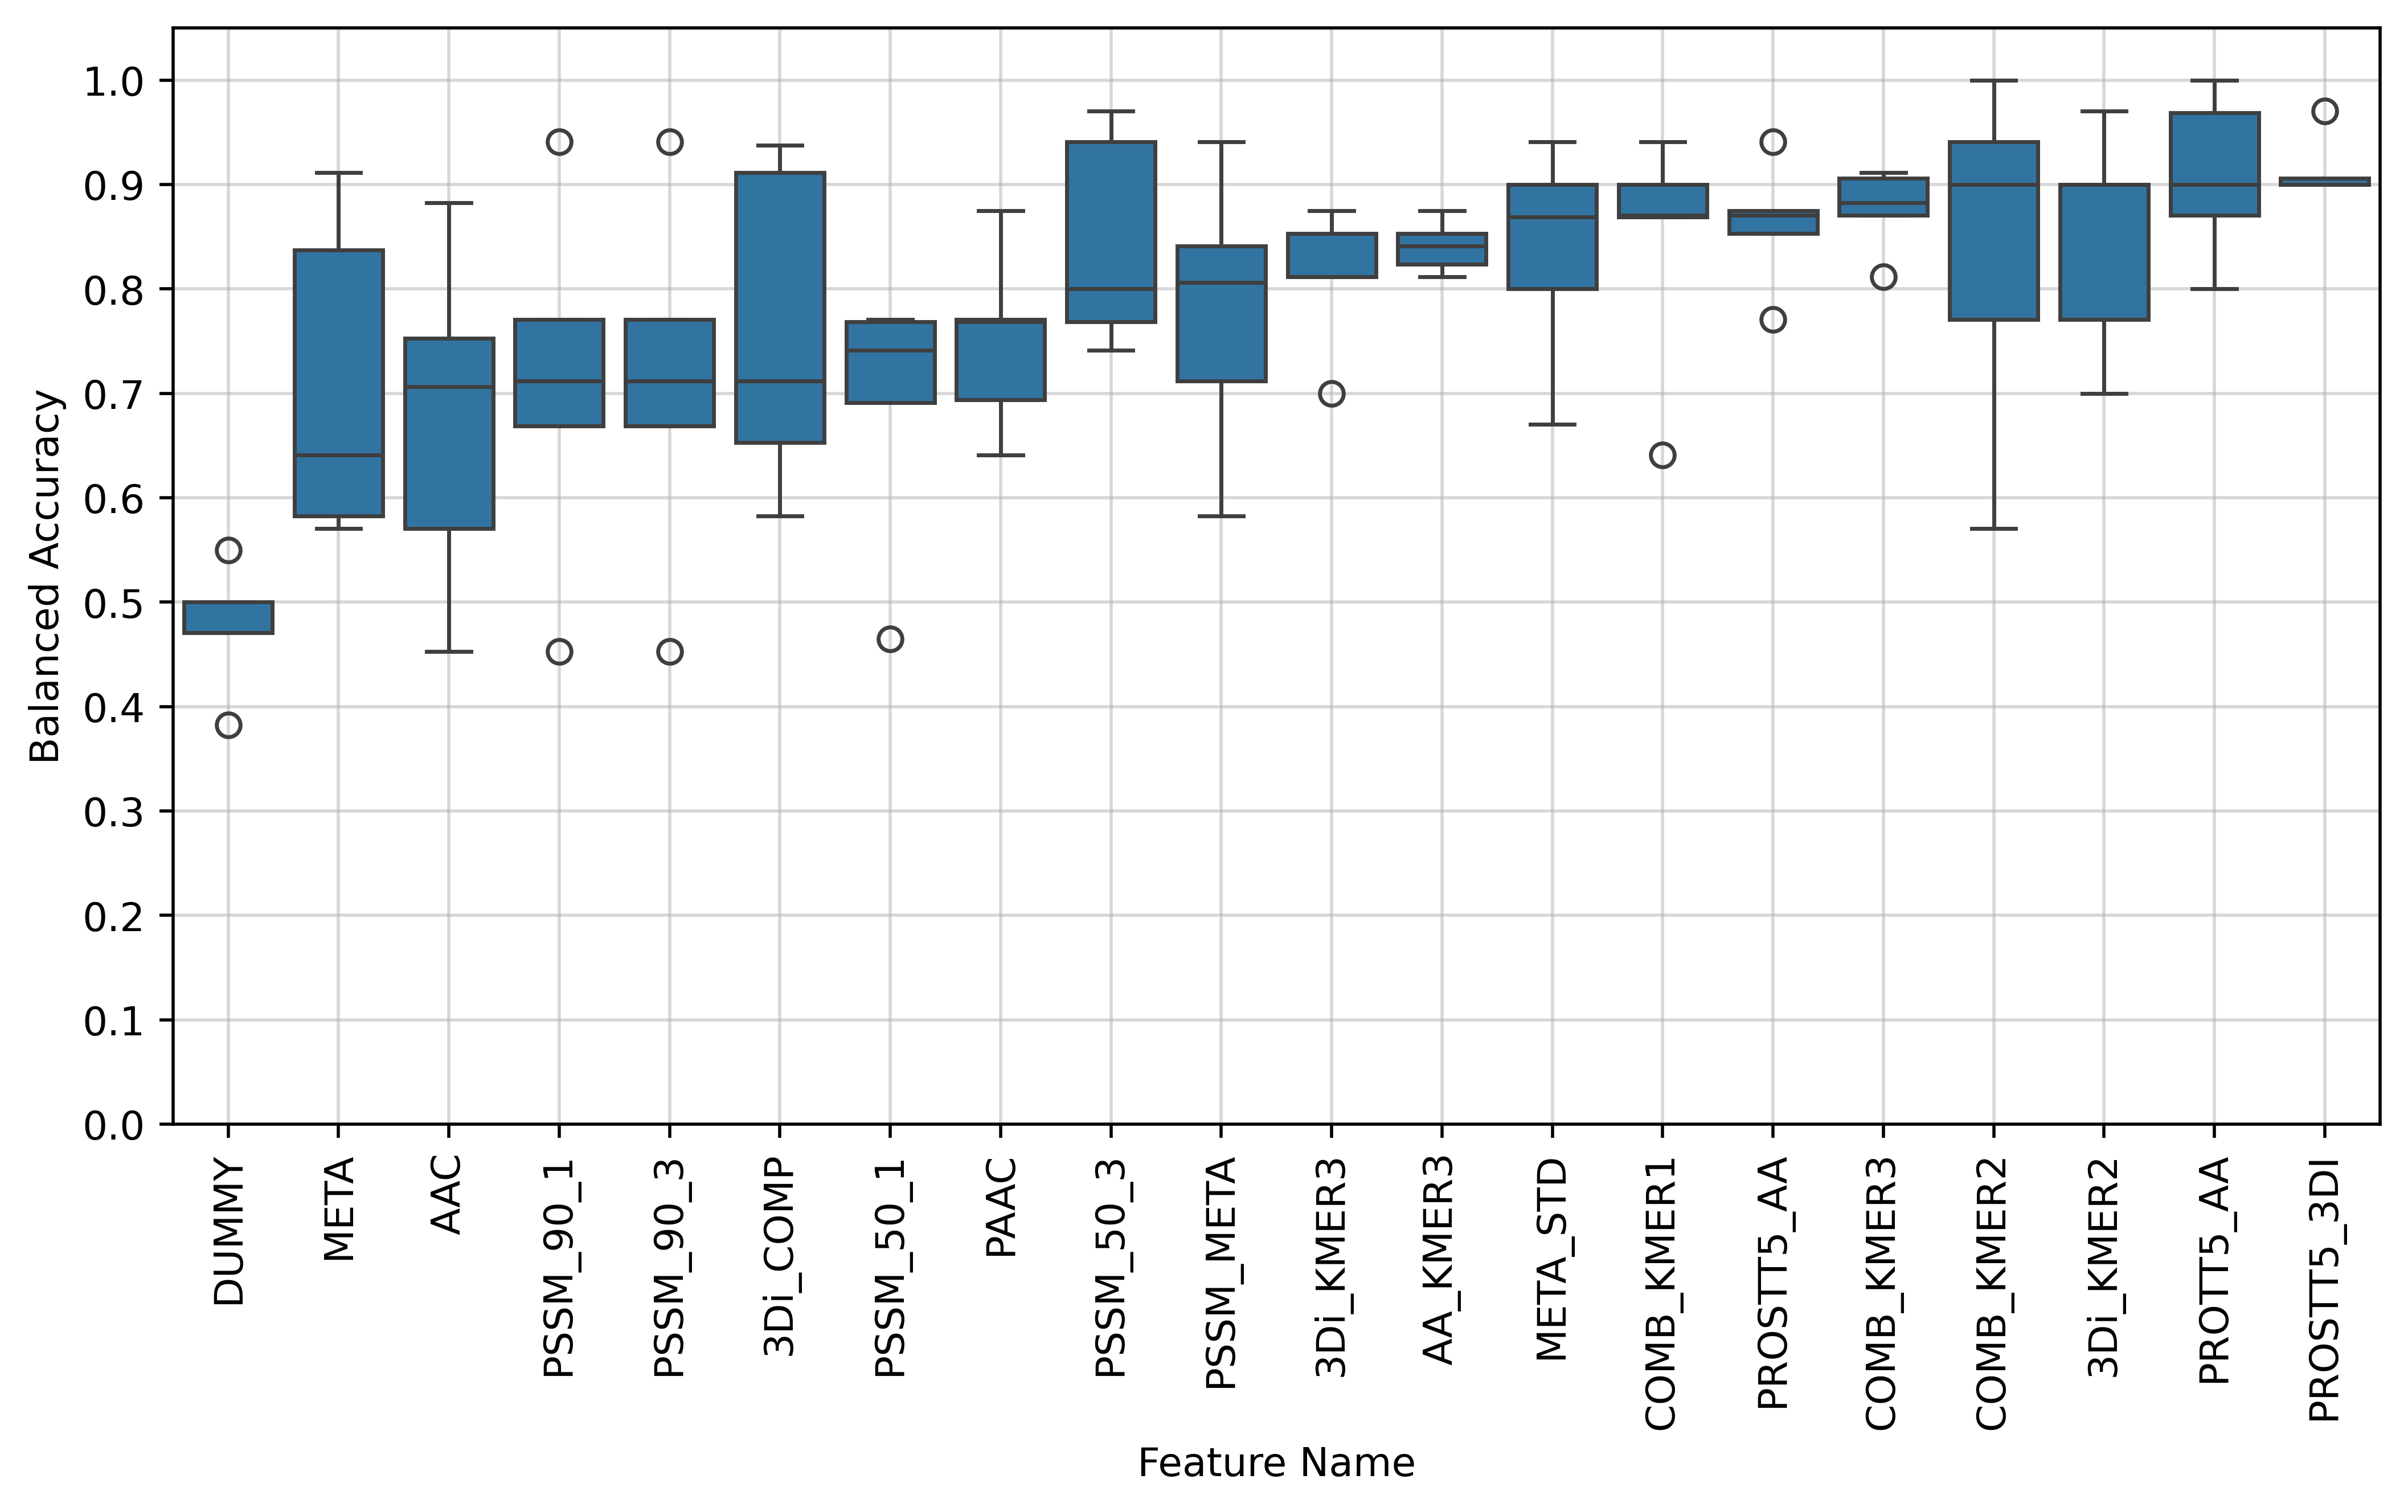

In [ ]:
from subpred.util import save_data, load_data
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RESULTS_FOLDER = "../data/results/"
TEST_NAME = "svc_human_sugar_amino_rep10"
RECALCULATE = not Path(RESULTS_FOLDER + TEST_NAME + ".pickle").exists()  # TODO

if RECALCULATE:
    # takes about 20 min

    # variancethreshold removes features, then selectkbest complains that more features are selected than available
    # because max_features = min(len(feature_names), 200).
    # in this case, selectkbest simply returns all remaining features, so nothing to worry about.
    # using variancethreshold to determine max_features could be seen as information sharing, therefore we avoid that
    results_rbf_svm = [
        (
            ml_dataset[0],
            nested_crossval(*ml_dataset, outer_cv=5, inner_cv=5, repeats=10),
        )
        for ml_dataset in ml_datasets
    ]

    results_long = list()
    for feature_name, test_results in results_rbf_svm:
        for test_result in test_results:
            results_long.append((feature_name, test_result))

    df_results_long = pd.DataFrame.from_records(
        results_long, columns=["Feature Name", "Balanced Accuracy"]
    )

    save_data(df_results_long, TEST_NAME, folder_path=RESULTS_FOLDER)
else:
    df_results_long = load_data(TEST_NAME, folder_path=RESULTS_FOLDER)

plt.figure(figsize=(10, 5), dpi=500)
df_results_long_stats = pd.concat(
    [
        df_results_long.groupby("Feature Name")["Balanced Accuracy"]
        .median()
        .rename("median_val"),
        df_results_long.groupby("Feature Name")["Balanced Accuracy"]
        .std()
        .rename("std_val"),
    ],
    axis=1,
)
df_results_long_stats = df_results_long_stats.sort_values(
    by=["median_val", "std_val"], ascending=[True, False]
)
display(df_results_long_stats)
sns.boxplot(
    df_results_long,
    x="Feature Name",
    y="Balanced Accuracy",
    order=df_results_long_stats.index,
)
df_results_long
plt.xticks(rotation=90)
plt.ylim((0, 1.05))
plt.grid(True, alpha=0.5)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig(RESULTS_FOLDER + TEST_NAME, bbox_inches="tight", dpi=300)

In [36]:
# TODO linear svm, linear svm with nyström, DNN -> other?
# TODO maybe find all sugar transporters against background of all proteins?